In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter


In [2]:
filesList = os.listdir('../src')
print(filesList)

['soil_data.csv', 'train_timeseries', 'counties.geojson', 'test_timeseries', 'validation_timeseries', 'counties.zip']


In [3]:
# dataDic = {"train": pd.read_csv("../src/train_timeseries/train_timeseries.csv"),
#            "test": pd.read_csv("../src/test_timeseries/test_timeseries.csv"),
#            "validation": pd.read_csv("../src/validation_timeseries/validation_timeseries.csv"),
#            "soil" : pd.read_csv("../src/soil_data.csv"),
#            }

In [4]:
# dataDic["train"].columns

In [5]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

In [6]:
# dfs = {
#     k: dataDic[k].set_index(['fips', 'date'])
#     for k in dataDic.keys() if k != "soil"
# }

# dfs["soil"] = dataDic["soil"]

In [7]:
batch_size = 128
output_weeks = 6
use_static = True
hidden_dim = 512
n_layers = 2
ffnn_layers = 2
dropout = 0.1
one_cycle = True
lr = 7e-5
epochs = 10
clip = 5


In [8]:
def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

In [9]:
def date_encode(date):
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    return (
        np.sin(2 * np.pi * date.timetuple().tm_yday / 366),
        np.cos(2 * np.pi * date.timetuple().tm_yday / 366),
    )

In [10]:
def loadXY(
    df,
    random_state=42,
    window_size=180, # how many days in the past (default/competition: 180)
    target_size=6, # how many weeks into the future (default/competition: 6)
    fuse_past=True, # add the past drought observations? (default: True)
    return_fips=False, # return the county identifier (do not use for predictions)
    encode_season=True, # encode the season using the function above (default: True) 
    use_prev_year=False, # add observations from 1 year prior?
):
    df = dfs[df]
    soil_df = dfs["soil"]
    time_data_cols = sorted(
        [c for c in df.columns if c not in ["fips", "date", "score"]]
    )
    static_data_cols = sorted(
        [c for c in soil_df.columns if c not in ["soil", "lat", "lon"]]
    )
    count = 0
    score_df = df.dropna(subset=["score"])
    X_static = np.empty((len(df) // window_size, len(static_data_cols)))
    X_fips_date = []
    add_dim = 0
    if use_prev_year:
        add_dim += len(time_data_cols)
    if fuse_past:
        add_dim += 1
        if use_prev_year:
            add_dim += 1
    if encode_season:
        add_dim += 2
    X_time = np.empty(
        (len(df) // window_size, window_size, len(time_data_cols) + add_dim)
    )
    y_past = np.empty((len(df) // window_size, window_size))
    y_target = np.empty((len(df) // window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0) == fips)]
        X = fips_df[time_data_cols].values
        y = fips_df["score"].values
        X_s = soil_df[soil_df["fips"] == fips][static_data_cols].values[0]
        for i in range(start_i, len(y) - (window_size + target_size * 7), window_size):
            X_fips_date.append((fips, fips_df.index[i : i + window_size][-1]))
            X_time[count, :, : len(time_data_cols)] = X[i : i + window_size]
            if use_prev_year:
                if i < 365 or len(X[i - 365 : i + window_size - 365]) < window_size:
                    continue
                X_time[count, :, -len(time_data_cols) :] = X[
                    i - 365 : i + window_size - 365
                ]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i : i + window_size])
            else:
                X_time[count, :, len(time_data_cols)] = interpolate_nans(
                    y[i : i + window_size]
                )
            if encode_season:
                enc_dates = [
                    date_encode(d) for f, d in fips_df.index[i : i + window_size].values
                ]
                d_sin, d_cos = [s for s, c in enc_dates], [c for s, c in enc_dates]
                X_time[count, :, len(time_data_cols) + (add_dim - 2)] = d_sin
                X_time[count, :, len(time_data_cols) + (add_dim - 2) + 1] = d_cos
            temp_y = y[i + window_size : i + window_size + target_size * 7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    print(f"loaded {count} samples")
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

In [11]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}


def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(X_time[:, :, index].reshape(-1, 1))
        X_time[:, :, index] = (
            scaler_dict[index]
            .transform(X_time[:, :, index].reshape(-1, 1))
            .reshape(-1, X_time.shape[-2])
        )
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:, index].reshape(-1, 1)
            )
        X_static[:, index] = (
            scaler_dict_static[index]
            .transform(X_static[:, index].reshape(-1, 1))
            .reshape(1, -1)
        )
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(y_past.reshape(-1, 1))
        y_past[:, :] = (
            scaler_dict_past[index]
            .transform(y_past.reshape(-1, 1))
            .reshape(-1, y_past.shape[-1])
        )
        return X_static, X_time, y_past
    return X_static, X_time

In [12]:
# X_tabular_train, X_time_train, y_target_train = loadXY("train")
# print("train shape", X_time_train.shape)
# X_tabular_validation, X_time_valid, y_target_valid, valid_fips = loadXY("validation", return_fips=True)
# print("validation shape", X_time_valid.shape)
# X_tabular_train, X_time_train = normalize(X_tabular_train, X_time_train, fit=True)
# X_tabular_validation, X_time_valid = normalize(X_tabular_validation, X_time_valid)

In [13]:
# X_tabular_test, X_time_test, y_target_test, test_fips = loadXY("test", return_fips=True)
# print("test shape", X_time_test.shape)
# X_tabular_test, X_time_test = normalize(X_tabular_test, X_time_test)

In [14]:
# import pickle
# # export all
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy", X_tabular_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_train.npy", X_time_train)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_train.npy", y_target_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy", X_tabular_validation)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_valid.npy", X_time_valid)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_valid.npy", y_target_valid)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy", X_tabular_test)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_test.npy", X_time_test)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_test.npy", y_target_test)
# with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "wb") as f:
#     pickle.dump(valid_fips, f)
# with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "wb") as f:
#     pickle.dump(test_fips, f)


In [15]:
import pickle
# import all
X_tabular_train = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy")
X_time_train = np.load("../data/processed_no_cat_and_no_tensors/X_time_train.npy")
y_target_train = np.load("../data/processed_no_cat_and_no_tensors/y_target_train.npy")
X_tabular_validation = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy")
X_time_valid = np.load("../data/processed_no_cat_and_no_tensors/X_time_valid.npy")
y_target_valid = np.load("../data/processed_no_cat_and_no_tensors/y_target_valid.npy")
X_tabular_test = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy")
X_time_test = np.load("../data/processed_no_cat_and_no_tensors/X_time_test.npy")
y_target_test = np.load("../data/processed_no_cat_and_no_tensors/y_target_test.npy")
with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "rb") as f:
    valid_fips = pickle.load(f)
with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "rb") as f:
    test_fips = pickle.load(f)

In [16]:
y_train_tensor = torch.tensor(y_target_train[:, :output_weeks])

# Flatten the target tensor to compute class frequencies
flat_labels = y_train_tensor.view(-1).numpy().round().astype(int)  # Shape: [observations * weeks]
class_counts = np.bincount(flat_labels)  # Count occurrences of each class
class_weights = 1.0 / class_counts       # Inverse of class frequencies

# Map class weights to each [i, j] in the target tensor
weights_per_sample = class_weights[y_train_tensor.numpy().round().astype(int)]  # Shape: [observations, weeks]

# Compute the average weight per observation (averaging over the 6 weeks)
sample_weights = weights_per_sample.mean(axis=1)  # Shape: [observations]

# Create a sampler for the training data
train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True,
)

# Prepare the datasets
train_data = TensorDataset(
    torch.tensor(X_time_train),
    torch.tensor(X_tabular_train),
    y_train_tensor,
)
valid_data = TensorDataset(
    torch.tensor(X_time_valid),
    torch.tensor(X_tabular_validation),
    torch.tensor(y_target_valid[:, :output_weeks]),
)

# DataLoaders with sampler for training and default for validation
train_loader = DataLoader(
    train_data, batch_size=batch_size, drop_last=False
)

valid_loader = DataLoader(
    valid_data, shuffle=False, batch_size=batch_size, drop_last=False
)

In [17]:
len(train_loader)

808

In [18]:
class HybridModel(nn.Module):
    def __init__(
        self,
        num_numerical_features,
        num_time_series_features,
        hidden_size,
        num_lstm_layers,
        num_fc_tabular_layers,
        num_fc_combined_layers,
        output_size,
        dropout
    ):
        super(HybridModel, self).__init__()
        self.num_lstm_layers = num_lstm_layers
        self.hidden_size = hidden_size

        tabular_fc_layers = []
        for _ in range(num_fc_tabular_layers):
            tabular_fc_layers.append(nn.Linear(num_numerical_features, num_numerical_features))
            tabular_fc_layers.append(nn.ReLU())
        self.tabular_fc_layers = nn.Sequential(
            *tabular_fc_layers, nn.Linear(num_numerical_features, num_numerical_features)
        )

        # TS branch
        self.lstm = nn.LSTM(
            input_size=num_time_series_features,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout,
        )

        self.dropout = nn.Dropout(dropout)

        combined_fc_layers = []
        input_dim = num_numerical_features + hidden_size

        for _ in range(num_fc_combined_layers):
            combined_fc_layers.append(nn.Linear(input_dim, hidden_size))
            combined_fc_layers.append(nn.ReLU())
            input_dim = hidden_size
        self.combined_fc_layers = nn.Sequential(
            *combined_fc_layers, nn.Linear(hidden_size, output_size)
        )

    def forward(self, time_series_data, numerical_data, hidden):
        batch_size = time_series_data.size(0)
        numerical_data = numerical_data.to(torch.float32)
        time_series_data = time_series_data.to(torch.float32)
        x1 = self.tabular_fc_layers(numerical_data)
        # Pass the time series data through the LSTM
        lstm_out, hidden = self.lstm(time_series_data)
        # Pass the data through the attention mechanism
        context_vector = lstm_out[:, -1, :]  # Last time step output
        x2 = self.dropout(context_vector)
        x = torch.cat((x1, x2), dim=1)
        x = self.combined_fc_layers(x)
        out = x.view(batch_size, -1)
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.lstm.parameters()).data
        hidden = (
            weight.new(self.num_lstm_layers, batch_size, self.hidden_size).zero_().to(device),
            weight.new(self.num_lstm_layers, batch_size, self.hidden_size).zero_().to(device),
        )
        return hidden

In [19]:
writer = SummaryWriter('../runs/simple_LSTM')

In [ ]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("using GPU")
else:
    device = torch.device("cpu")
    print("using CPU")

model = HybridModel(
    num_numerical_features=X_tabular_train.shape[-1],
    num_time_series_features=X_time_train.shape[-1],
    hidden_size=hidden_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=2,
    output_size=output_weeks,
    dropout=dropout,
)

model.to(device)
loss_function = nn.HuberLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)
counter = 0
valid_loss_min = np.inf
torch.manual_seed(42)
np.random.seed(42)

for i in range(epochs):
    h = model.init_hidden(batch_size)
    for k, (inputs, static, labels) in tqdm(enumerate(train_loader),
                                            desc=f"epoch {i+1}/{epochs}",
                                            total=len(train_loader),):
        model.train()
        counter += 1
        if len(inputs) < batch_size:
            h = model.init_hidden(len(inputs))
        h = tuple([each.data for each in h])
        inputs, labels, static = (
            inputs.to(device),
            labels.to(device),
            static.to(device),
        )
        model.zero_grad()
        output, h = model(inputs, static, h)
        loss = loss_function(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            if k == len(train_loader) - 1 or k == (len(train_loader) - 1) // 2:
                val_h = model.init_hidden(batch_size)
                val_losses = []
                model.eval()
                labels = []
                preds = []
                raw_labels = []
                raw_preds = []
                for inp, stat, lab in valid_loader:
                    if len(inp) < batch_size:
                        val_h = model.init_hidden(len(inp))
                    val_h = tuple([each.data for each in val_h])
                    inp, lab, stat = inp.to(device), lab.to(device), stat.to(device)
                    out, val_h = model(inp, stat, val_h)
                    val_loss = loss_function(out, lab.float())
                    val_losses.append(val_loss.item())
                    for labs in lab:
                        labels.append([int(l.round()) for l in labs])
                        raw_labels.append([float(l) for l in labs])
                    for pred in out:
                        preds.append([int(p.round()) for p in pred])
                        raw_preds.append([float(p) for p in pred])
                # log data
                labels = np.array(labels)
                preds = np.clip(np.array(preds), 0, 5)
                raw_preds = np.array(raw_preds)
                raw_labels = np.array(raw_labels)
                for i in range(output_weeks):
                    log_dict = {
                        "loss": float(loss),
                        "epoch": counter / len(train_loader),
                        "step": counter,
                        "lr": optimizer.param_groups[0]["lr"],
                        "week": i + 1,
                    }
                    # w = f'week_{i+1}_'
                    w = ""
                    log_dict[f"{w}validation_loss"] = np.mean(val_losses)
                    log_dict[f"{w}macro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="macro"
                    )
                    log_dict[f"{w}micro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="micro"
                    )
                    log_dict[f"{w}mae"] = mean_absolute_error(
                        raw_labels[:, i], raw_preds[:, i]
                    )
                    print(log_dict)
                    writer.add_scalars("Loss(Hubber)", {'train': loss,
                                                     'validation': log_dict[f"{w}validation_loss"]},
                                                     counter)
                    writer.add_scalars("F1(MSE)", {'macro': log_dict[f"{w}macro_f1"],
                                                   'micro': log_dict[f"{w}micro_f1"]},
                                                   counter)
                    writer.add_scalar("MAE", log_dict[f"{w}mae"],
                                      counter)
                    writer.add_scalar("Learning-Rate", log_dict["lr"],
                                      counter)
                    for j, f1 in enumerate(
                        f1_score(labels[:, i], preds[:, i], average=None)
                    ):
                        log_dict[f"{w}{id2class[j]}_f1"] = f1
                    model.train()
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), "../models/lstm_0_each_batch.pt")
                    print(
                        "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                            valid_loss_min, np.mean(val_losses)
                        )
                    )
                    valid_loss_min = np.mean(val_losses)

using GPU


epoch 1/15:  50%|████▉     | 401/808 [02:14<02:16,  2.97it/s]

In [24]:
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = HybridModel(
    num_numerical_features=X_tabular_train.shape[-1],
    num_time_series_features=X_time_train.shape[-1],
    hidden_size=hidden_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=2,
    output_size=output_weeks,
    dropout=dropout,
)

# model.load_state_dict(torch.load("models/MH_Hyper/MH_Hyper_12.pt", weights_only=True))
model.load_state_dict(torch.load("../models/simple_lstm.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


HybridModel(
  (tabular_fc_layers): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
  )
  (lstm): LSTM(21, 512, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (combined_fc_layers): Sequential(
    (0): Linear(in_features=542, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [26]:
def predict(x, static):
    out, _= model(torch.tensor(x), static, val_h)
    return out

In [27]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    # "fips": [],
    # "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for x, static, y in tqdm(
    valid_loader, # ou test_loader
    desc="validation predictions...",):
    val_h = tuple([each.data.to(device) for each in model.init_hidden(len(x))])
    x, static, y = x.to(device), static.to(device), y.to(device)
    with torch.no_grad():
        pred = predict(x, static).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        # dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        # dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

validation predictions...:   0%|          | 0/69 [00:00<?, ?it/s]/tmp/ipykernel_1423726/218339046.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out, _= model(torch.tensor(x), static, val_h)
validation predictions...: 100%|██████████| 69/69 [00:17<00:00,  4.05it/s]


In [ ]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

Week 1 MAE 0.123 F1 0.819
Week 2 MAE 0.193 F1 0.719
Week 3 MAE 0.25 F1 0.65
Week 4 MAE 0.303 F1 0.578
Week 5 MAE 0.349 F1 0.525
Week 6 MAE 0.388 F1 0.484


'\nWeek 1 MAE 0.147 F1 0.757\nWeek 2 MAE 0.203 F1 0.704\nWeek 3 MAE 0.256 F1 0.643\nWeek 4 MAE 0.307 F1 0.569\nWeek 5 MAE 0.355 F1 0.54\nWeek 6 MAE 0.396 F1 0.484\n'

In [ ]:
df

,y_pred,y_pred_rounded,y_true,week
0,0.010860,0,0.0000,0
1,0.038232,0,0.0000,0
2,0.011055,0,0.0000,0
3,0.039715,0,0.0000,0
4,0.680303,1,0.7767,0
...,...,...,...,...
52483,0.120630,0,0.9964,5
52484,0.991474,1,1.9211,5
52485,0.192867,0,0.0000,5
52486,0.160236,0,0.0000,5


In [ ]:
for cat in df["y_true"].round().astype(int).unique():
    df_cat = df[df["y_true"].round().astype(int) == cat]
    print(f"Accuracy {cat}:")
    print((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())

Accuracy 0:
0.9198222731833167
Accuracy 1:
0.5292878213232195
Accuracy 2:
0.5074121135112241
Accuracy 3:
0.5595698924731183
Accuracy 5:
0.441025641025641
Accuracy 4:
0.6237054085155351


(array([6.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 5.0000e+00,
        9.0000e+00, 1.9000e+01, 3.3000e+01, 1.6000e+01, 3.0000e+01,
        6.1000e+01, 1.1000e+02, 1.1400e+02, 1.3200e+02, 1.8000e+02,
        3.5200e+02, 4.9600e+02, 7.3900e+02, 1.0070e+03, 1.4400e+03,
        4.4330e+03, 1.6366e+04, 1.6199e+04, 2.4490e+03, 1.8720e+03,
        1.4750e+03, 1.7110e+03, 1.5900e+03, 5.1600e+02, 3.2500e+02,
        2.3500e+02, 2.0100e+02, 1.8000e+02, 8.5000e+01, 3.6000e+01,
        2.2000e+01, 1.5000e+01, 1.6000e+01, 6.0000e+00, 5.0000e+00]),
 array([-3.69941616, -3.53307228, -3.36672841, -3.20038453, -3.03404065,
        -2.86769678, -2.7013529 , -2.53500902, -2.36866515, -2.20232127,
        -2.03597739, -1.86963352, -1.70328964, -1.53694576, -1.37060189,
        -1.20425801, -1.03791413, -0.87157026, -0.70522638, -0.5388825 ,
        -0.37253862, -0.20619475, -0.03985087,  0.12649301,  0.29283688,
         0.45918076,  0.62552464,  0.79186851,  0.95821239,  1.12455627,
         1.29090

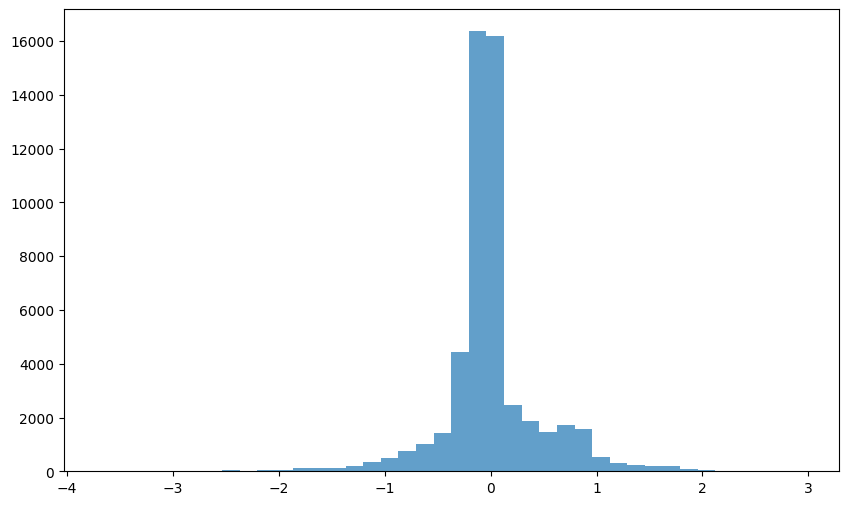

In [ ]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist(df['y_true'] - df['y_pred'], bins=40, alpha=0.7, label='error')

Text(0, 0.5, 'Residuals')

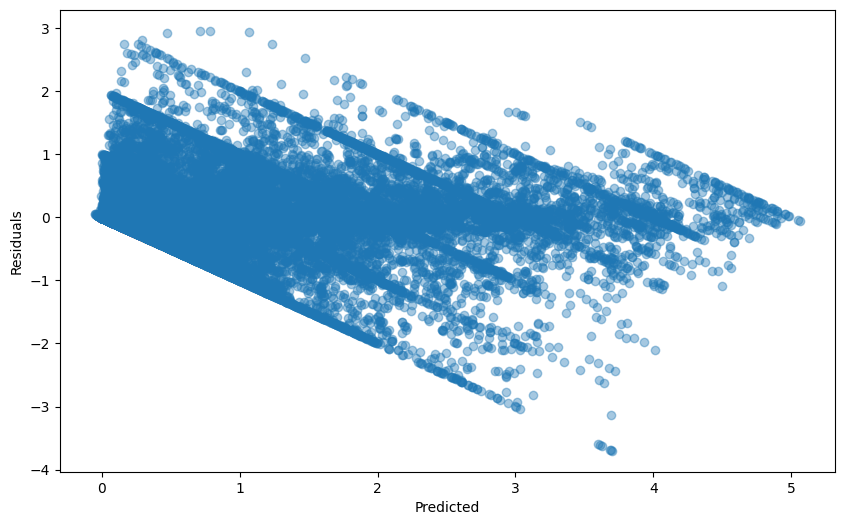

In [ ]:
# predicted values vs residuals
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'] - df['y_pred'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("Residuals")

Text(0, 0.5, 'True')

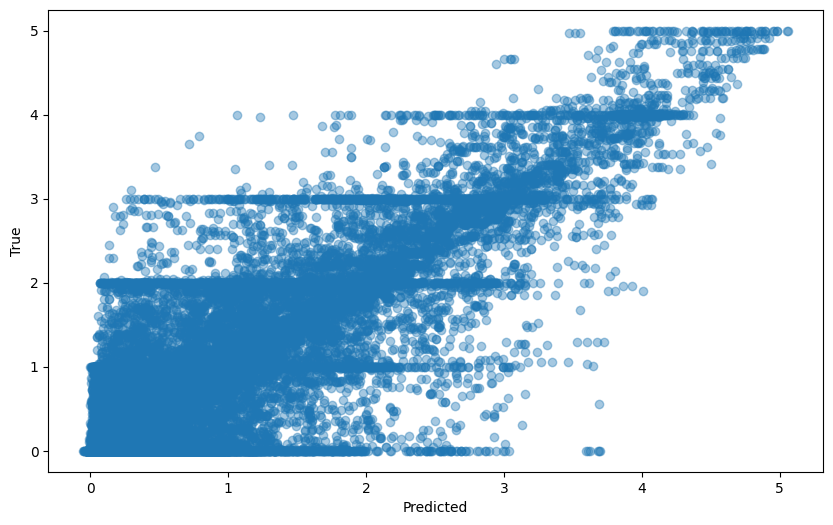

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("True")